In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [20]:
df = pd.read_csv('../data/okcupid_preprocessed.csv')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59934 entries, 0 to 59933
Data columns (total 37 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  59934 non-null  int64  
 1   sex                         59934 non-null  int64  
 2   drinks                      59934 non-null  float64
 3   drugs                       59934 non-null  int64  
 4   education                   51629 non-null  float64
 5   height                      59934 non-null  float64
 6   job                         51739 non-null  object 
 7   last_online                 59934 non-null  object 
 8   smokes                      59934 non-null  float64
 9   Response rate               59934 non-null  float64
 10  age                         59934 non-null  int64  
 11  diet                        59934 non-null  int64  
 12  total_essay_len             59934 non-null  int64  
 13  essay_answered_count        599

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
features = [
    'sex', 'orientation_1', 'diet',
    'drugs', 'education', 'height',
    'body_type_average', 'body_type_curvy', 'body_type_fit',
    'body_type_slim', 'smokes', 'drinks',
    'job_score', 'religion_religion', 'status_encoding',
    'age', 'Response rate', 'total_essay_len',
    'essay_answered_count', 'niche_score']

X = df[features]
y = df['is_churned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.90      0.79      7949
           1       0.57      0.27      0.37      4038

    accuracy                           0.69     11987
   macro avg       0.64      0.58      0.58     11987
weighted avg       0.66      0.69      0.65     11987



In [23]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

grid_searchcv = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
)
grid_searchcv.fit(X_train, y_train)
print("Best Hyperparameters:", grid_searchcv.best_params_)

c:\Users\rbgh0\miniconda3\envs\pystudy_env\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Hyperparameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [24]:
best_rf = grid_searchcv.best_estimator_
y_pred_best = best_rf.predict(X_test)

from sklearn.metrics import classification_report
print("\n[튜닝 후 Classification Report]")
print(classification_report(y_test, y_pred_best))


[튜닝 후 Classification Report]
              precision    recall  f1-score   support

           0       0.75      0.72      0.73      7949
           1       0.49      0.54      0.51      4038

    accuracy                           0.66     11987
   macro avg       0.62      0.63      0.62     11987
weighted avg       0.66      0.66      0.66     11987



In [25]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    best_rf, X_train, y_train, cv=5, scoring='f1', n_jobs=-1
)
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())
print("\n[최종 모델 Classification Report]")
print(classification_report(y_test, y_pred_best))

Cross-validation scores: [0.49985088 0.49848668 0.50981559 0.50881612 0.51536855]
Mean CV score: 0.5064675632375717

[최종 모델 Classification Report]
              precision    recall  f1-score   support

           0       0.75      0.72      0.73      7949
           1       0.49      0.54      0.51      4038

    accuracy                           0.66     11987
   macro avg       0.62      0.63      0.62     11987
weighted avg       0.66      0.66      0.66     11987



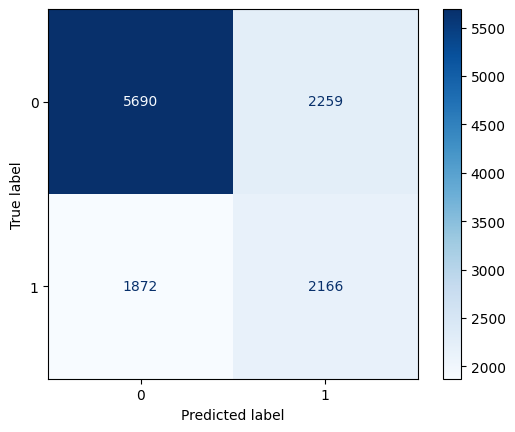

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

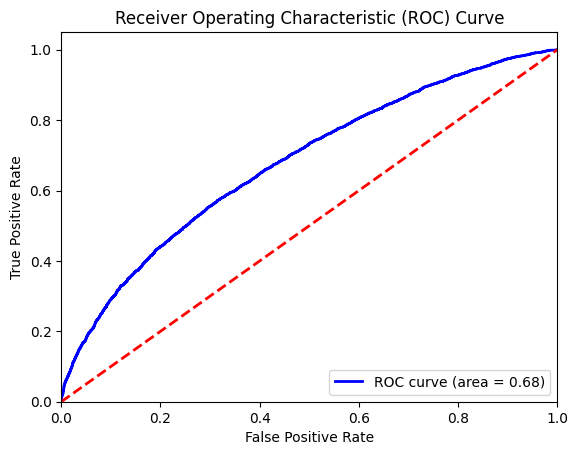

In [27]:
# ROC곡선
from sklearn.metrics import roc_curve, auc
y_prob = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

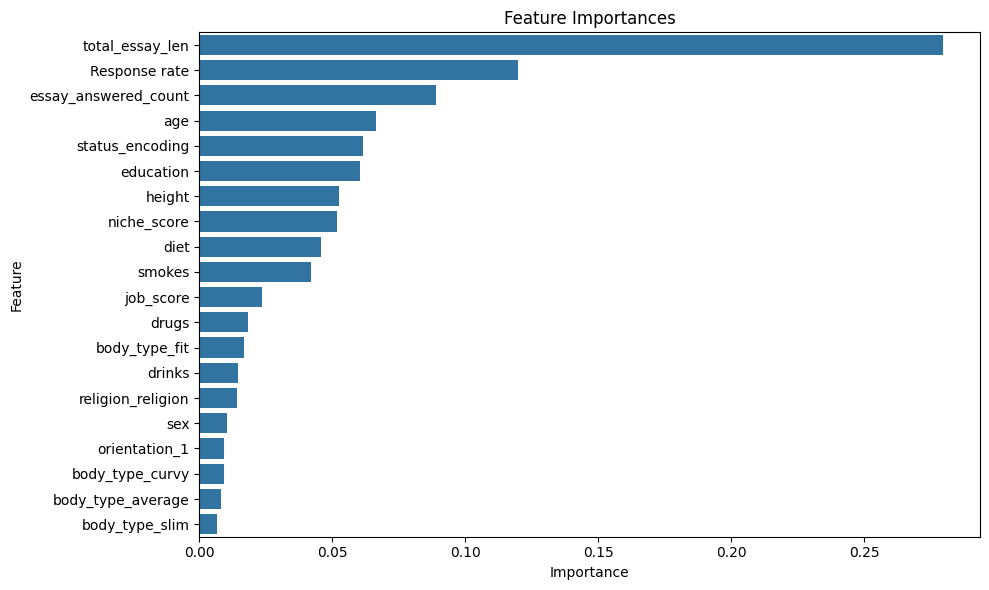

In [28]:
# 특성 중요도
importances = best_rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [31]:
# optuna
import optuna

def objective(trial):
    param_grid = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200]),
        'max_depth': trial.suggest_categorical('max_depth', [None, 10, 20, 30]),
        'min_samples_split': trial.suggest_categorical('min_samples_split', [2, 5, 10]),
        'min_samples_leaf': trial.suggest_categorical('min_samples_leaf', [1, 2, 4]),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced'])
    }
    rf_model = RandomForestClassifier(random_state=42, **param_grid)
    cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
    return cv_scores.mean()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)


c:\Users\rbgh0\miniconda3\envs\pystudy_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2026-02-24 01:00:56,507] A new study created in memory with name: no-name-8acfbc8d-30d5-4188-8204-a201c311008d
[I 2026-02-24 01:01:22,778] Trial 0 finished with value: 0.3741046991035735 and parameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.3741046991035735.
[I 2026-02-24 01:01:34,241] Trial 1 finished with value: 0.505214090912317 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.505214090912317.
[I 2026-02-24 01:01:53,657] Trial 2 finished with value: 0.34182976288584116 and parameters: {'n_estimators': 20

In [32]:
# Optuna 최적 하이퍼파라미터 출력
optuna_best_params = study.best_params
print("Optuna Best Hyperparameters:", optuna_best_params)
best_rf_optuna = RandomForestClassifier(random_state=42, **optuna_best_params)
best_rf_optuna.fit(X_train, y_train)
y_pred_optuna = best_rf_optuna.predict(X_test)
print("\n[Optuna 튜닝 후 Classification Report]")
print(classification_report(y_test, y_pred_optuna))


Optuna Best Hyperparameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4, 'class_weight': 'balanced'}

[Optuna 튜닝 후 Classification Report]
              precision    recall  f1-score   support

           0       0.75      0.71      0.73      7949
           1       0.49      0.54      0.51      4038

    accuracy                           0.66     11987
   macro avg       0.62      0.63      0.62     11987
weighted avg       0.66      0.66      0.66     11987



In [33]:
# optuna로 튜닝한 모델 평가
optuna_rf = RandomForestClassifier(random_state=42, **optuna_best_params)
optuna_rf.fit(X_train, y_train)
y_pred_optuna = optuna_rf.predict(X_test)
print("\n[Optuna 튜닝 후 Classification Report]")
print(classification_report(y_test, y_pred_optuna))


[Optuna 튜닝 후 Classification Report]
              precision    recall  f1-score   support

           0       0.75      0.71      0.73      7949
           1       0.49      0.54      0.51      4038

    accuracy                           0.66     11987
   macro avg       0.62      0.63      0.62     11987
weighted avg       0.66      0.66      0.66     11987



In [34]:
# 모델 저장
import joblib
joblib.dump(optuna_rf, '../models/optuna_rf_clf_model.pkl')

['../models/optuna_rf_clf_model.pkl']